In [1]:
import time

import numpy as np

from scipy.interpolate import RectBivariateSpline
from scipy import spatial

from astropy.io import fits
from astropy import table
from astropy import visualization
from astropy import modeling

from photutils import psf

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

The imviz cell below requires the `jdaviz` package (https://github.com/spacetelescope/jdaviz) and `sidecar` (both should be pip-installable), but can be skipped if you don't want the interactive visualization.  Just skip all other cells that have "imviz" in them too.

In [3]:
from jdaviz import Imviz
from IPython.display import display
import sidecar

imviz = Imviz()

sc = sidecar.Sidecar(title='Imviz')
with sc:
    display(imviz.app)

In [4]:
psf_r = fits.open('psf/DES1000+0500_r5091p05_r_psfcat.psf')
psf_r_starlist_obj = table.Table.read('psf/DES1000+0500_r5091p05_r_psfex-starlist.fits', hdu='LDAC_OBJECTS')

In [5]:
im_r = fits.open('DES1000+0500_r5091p05_r.fits.fz')
im_rn = fits.open('DES1000+0500_r5091p05_r_nobkg.fits.fz')

# Quick look at Sextans B region 

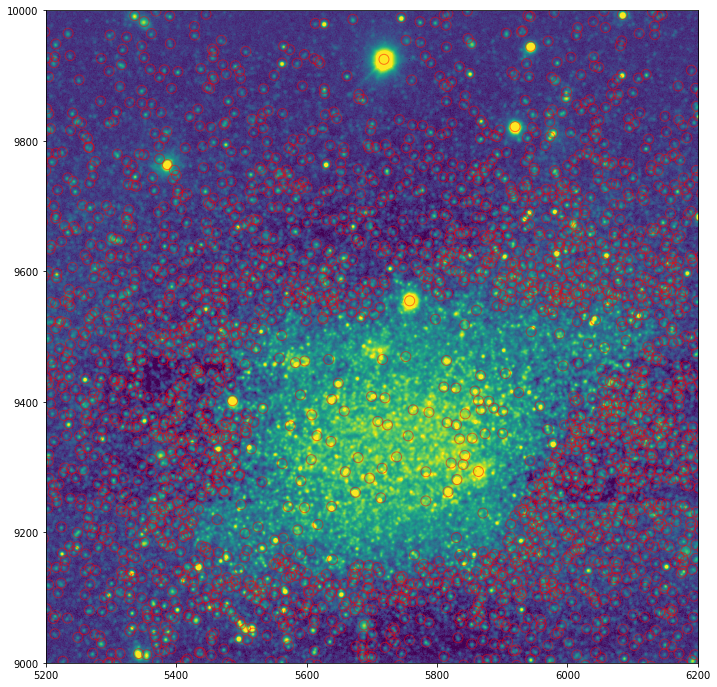

In [6]:
fig1 = plt.figure(figsize=(12, 12))
visualization.imshow_norm(im_r['SCI'].data, 
                          interval=visualization.AsymmetricPercentileInterval(.1, 99.7),
                          stretch=visualization.AsinhStretch())
plt.scatter(psf_r_starlist_obj['X_IMAGE'], psf_r_starlist_obj['Y_IMAGE'], ec='r', fc='none', s=100, alpha=.5)

plt.xlim(5200,6200)
plt.ylim(9000,10000);

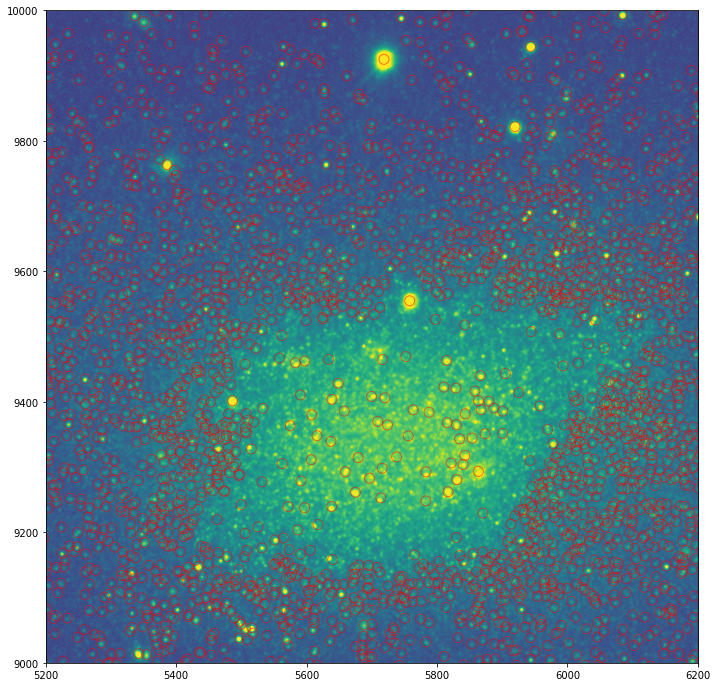

In [7]:
fig2 = plt.figure(figsize=(12, 12))

visualization.imshow_norm(im_rn['SCI'].data, 
                          interval=visualization.AsymmetricPercentileInterval(.1, 99.8),
                          stretch=visualization.AsinhStretch())
plt.scatter(psf_r_starlist_obj['X_IMAGE'], psf_r_starlist_obj['Y_IMAGE'], ec='r', fc='none', s=100, alpha=.5)

plt.xlim(5200,6200)
plt.ylim(9000,10000);

# "edge" field 

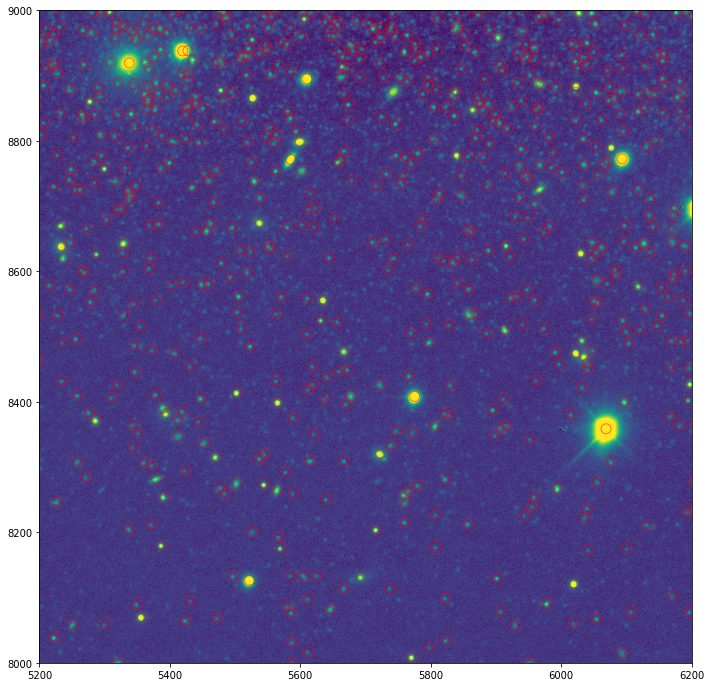

In [8]:
fig1.axes[0].set_ylim(8000,9000)
fig1

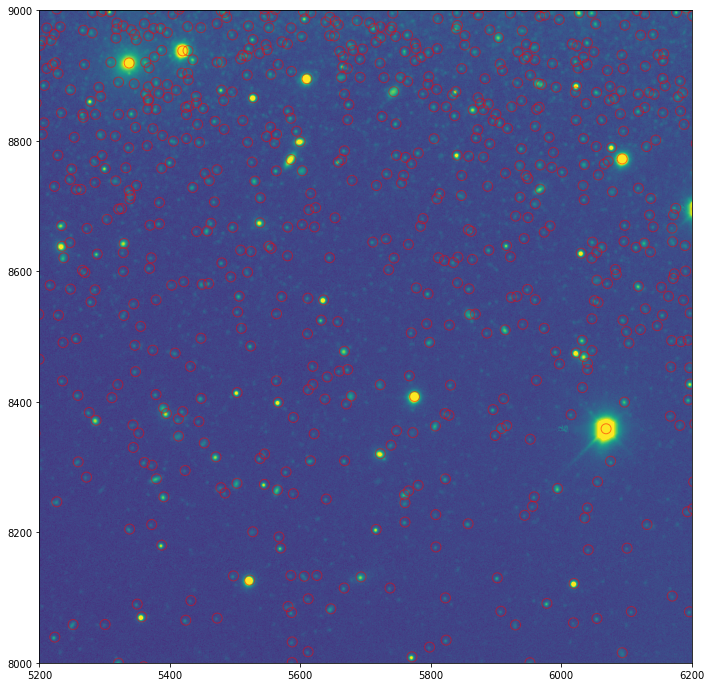

In [9]:
fig2.axes[0].set_ylim(8000,9000)
fig2

Try extracting this out for testing purposes, and just make sure we've got the same field:

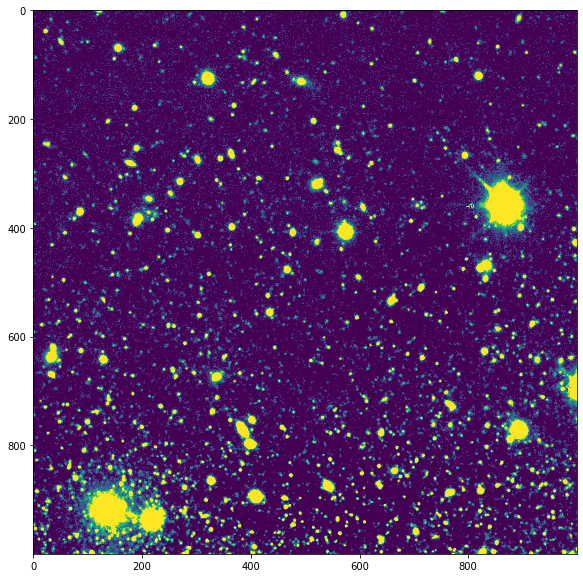

In [10]:
edge_data_r = im_r['SCI'].data[8000:9000, 5200:6200]
plt.figure(figsize=(10,10))
plt.imshow(edge_data_r,vmin=0,vmax=10)

# PSF model

See https://psfex.readthedocs.io/en/latest/Appendices.html for a description of the psf file format

In [11]:
psf_r[1].header

XTENSION= 'BINTABLE'           / THIS IS A BINARY TABLE (FROM THE LDACTOOLS)    
BITPIX  =                    8 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                89304 / BYTES PER ROW                                  
NAXIS2  =                    1 / NUMBER OF ROWS                                 
PCOUNT  =                    0 / RANDOM PARAMETER COUNT                         
GCOUNT  =                    1 / GROUP COUNT                                    
TFIELDS =                    1 / FIELDS PER ROWS                                
EXTNAME = 'PSF_DATA'           / TABLE NAME                                     
LOADED  =                 1854 / Number of loaded sources                       
ACCEPTED=                 1714 / Number of accepted sources                     
CHI2    =           1.10655300 / Final reduced chi2                             
POLNAXIS=                   

In [12]:
psf_r_data = psf_r[1].data['PSF_MASK'][0]
psf_r_data.shape

(6, 61, 61)

0 0.050116073
1 0.00042735037
2 0.00095075386
3 0.0007769377
4 0.0011563281
5 0.0016749037


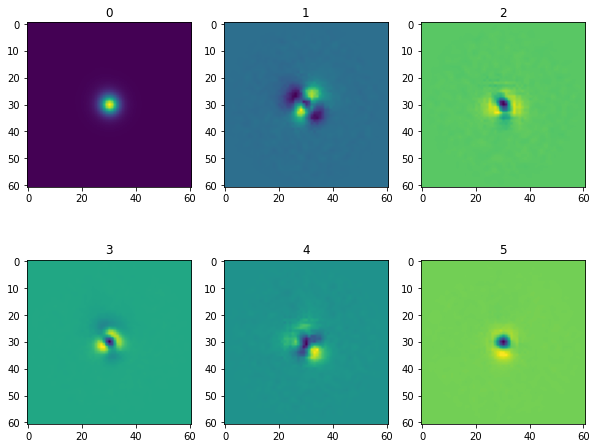

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(psf_r_data[i])
    ax.set_title(str(i))
    print(i, np.max(psf_r_data[i]))

In [14]:
class PSFExPSF(modeling.Fittable2DModel):
    def __init__(self, fitsfile, **kwargs):
        doclose = False
        if isinstance(fitsfile, str):
            fitsfile = fits.open(fitsfile)
            doclose = True
        try:
            self.hdr = fitsfile['PSF_DATA'].header.copy()
            self.psf_data = fitsfile['PSF_DATA'].data['PSF_MASK'][0].copy()
            
            assert len(self.psf_data.shape) == 3
            assert self.hdr['POLNAME1'] == 'XWIN_IMAGE'
            assert self.hdr['POLNAME2'] == 'YWIN_IMAGE'
            assert self.hdr['POLNGRP'] == 1
        finally:
            if doclose:
                fitsfile.close()
                
        super().__init__(**kwargs)
        
    @property
    def psf_shape(self):
        return self.psf_data.shape[1:]
                
    def psf_at(self, x, y, renorm=False):
        xpol = (x - self.hdr['POLZERO1']) / self.hdr['POLSCAL1']
        ypol = (y - self.hdr['POLZERO2']) / self.hdr['POLSCAL2']
        
        psf = np.zeros_like(self.psf_data[0])
        for d in range(self.hdr['POLDEG1'] + 1):
            for ypow in range(d+1):
                xpow = d - ypow
                i = xpow + ypow * (self.hdr['POLDEG1']+1)-ypow*(ypow-1)//2
                psf += self.psf_data[i] * xpol**xpow * ypol**ypow
            
        # there's a cleverer solution at https://galsim-developers.github.io/GalSim/_build/html/_modules/galsim/des/des_psfex.html, but this made sense to me
        if renorm:
            psf = psf/np.sum(psf)
        return psf
    
    def interpolator_at(self, x, y, renorm=False):
        psfat = self.psf_at(x, y, renorm)
        xg = np.arange(psfat.shape[0]) - (psfat.shape[0]+1)/2
        yg = np.arange(psfat.shape[1]) - (psfat.shape[1]+1)/2
        return RectBivariateSpline(xg, yg, psfat)
    
    x_0 = modeling.Parameter(default=0)
    y_0 = modeling.Parameter(default=0)
    flux = modeling.Parameter(default=1)
    
    def evaluate(self, x, y, x_0, y_0, flux):
        iterp0 =  self.interpolator_at(x_0, y_0)
        return flux*iterp0(x, y, grid=False)
    
    fit_deriv = None

Test that this does something sensible to reproduce the PSF:

Text(0, 0.5, 'residual rescaled')

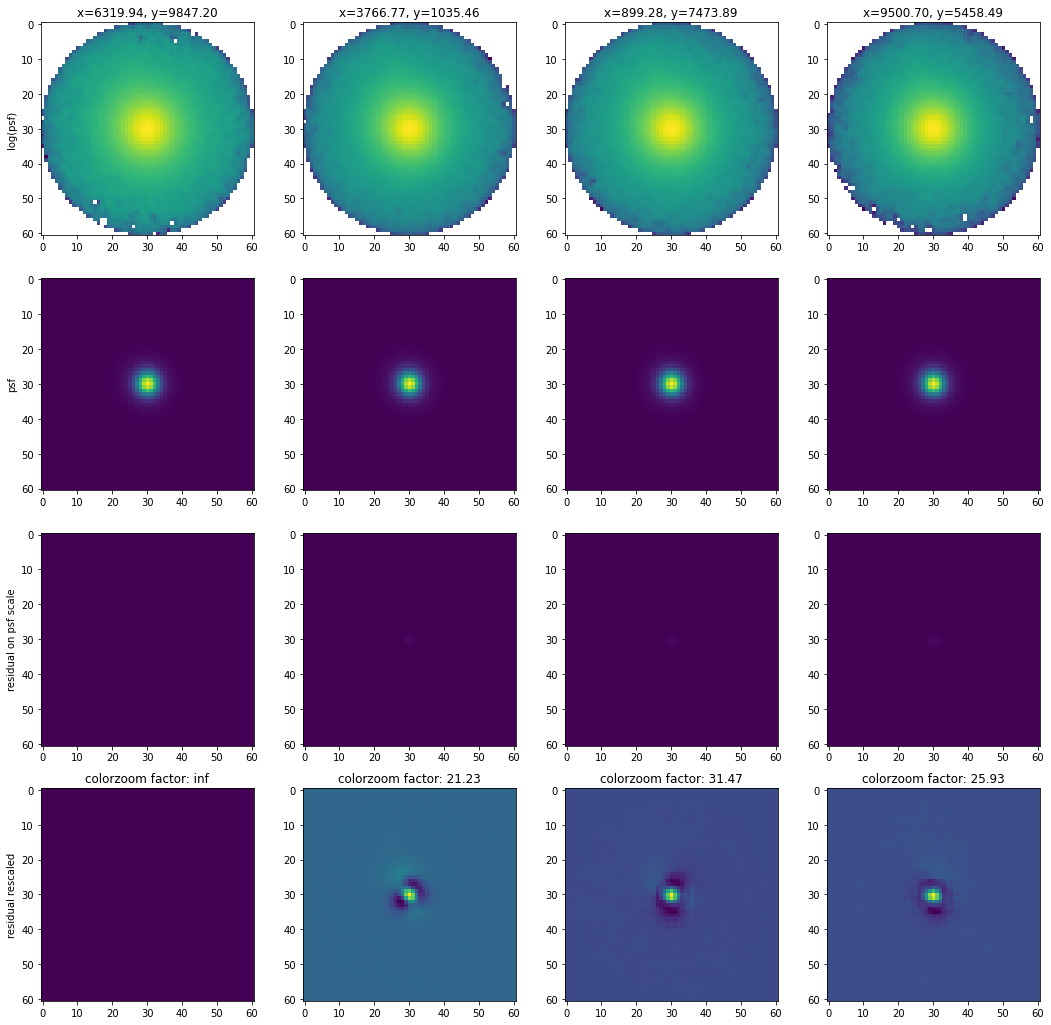

In [15]:
psf_model_r = PSFExPSF(psf_r)
fig, axs = plt.subplots(4, 4, figsize=(18, 18))
p0 = None
for ax1, ax2, ax3, ax4 in zip(*axs):
    x, y = np.random.rand(2)
    x *= im_r['SCI'].shape[0]
    y *= im_r['SCI'].shape[1]
    
    p = psf_model_r.psf_at(x, y)
    if p0 is None:
        p0 = p
    
    ax1.set_title('x={:.2f}, y={:.2f}'.format(x, y))
    
    ax1.imshow(np.log(p))
    
    ims2 = ax2.imshow(p, vmin=0)
    ax3.imshow(p-p0, vmin=0, vmax=ims2.get_clim()[1])
    ims4 = ax4.imshow(p-p0)
    ax4.set_title('colorzoom factor: {:.2f}'.format(np.ptp(ims2.get_clim())/np.ptp(ims4.get_clim())))
    
axs[0, 0].set_ylabel('log(psf)')
axs[1, 0].set_ylabel('psf')
axs[2, 0].set_ylabel('residual on psf scale')
axs[3, 0].set_ylabel('residual rescaled')

# Try running photutils on the test field to see if it look anything like what psfex gave us

In [16]:
psf_fwhm = psf_r[1].header['PSF_FWHM']
psf_fwhm

4.44924212

In [17]:
phot = psf.DAOPhotPSFPhotometry(5, 10, psf_fwhm, psf_model_r, 15)
t1 = time.time()
res = phot(edge_data_r)
t2 = time.time()
print('dt', t2 - t1)
res

dt 42.7723708152771


<Table length=3438>
       x_0               x_fit        ... group_id iter_detected
     float64            float64       ...  int64       int64    
------------------ ------------------ ... -------- -------------
118.56043645435287 -41222.94782442203 ...        1             1
 570.2757745465952  5646.144019840758 ...        2             1
 893.5319245905948  893.5319245905948 ...        3             1
411.04280882177375 411.04280882177375 ...        4             1
245.74843848675698 245.74843848675698 ...        5             1
 62.59858104502366  62.59858104502366 ...        6             1
               ...                ... ...      ...           ...
 426.4619248883236  426.4619248883236 ...     1105             3
 448.2165175687861  448.2165175687861 ...     1106             3
  546.940227461242   546.940227461242 ...     1107             3
 617.8307087082461  617.8307087082461 ...     1108             3
 915.1395226126151  915.1395226126151 ...     1109             3
 997.1935031703879  997.1935031703879 ...     1110             3
 212.5992557033277  212.5992557033277 ...     1111             3

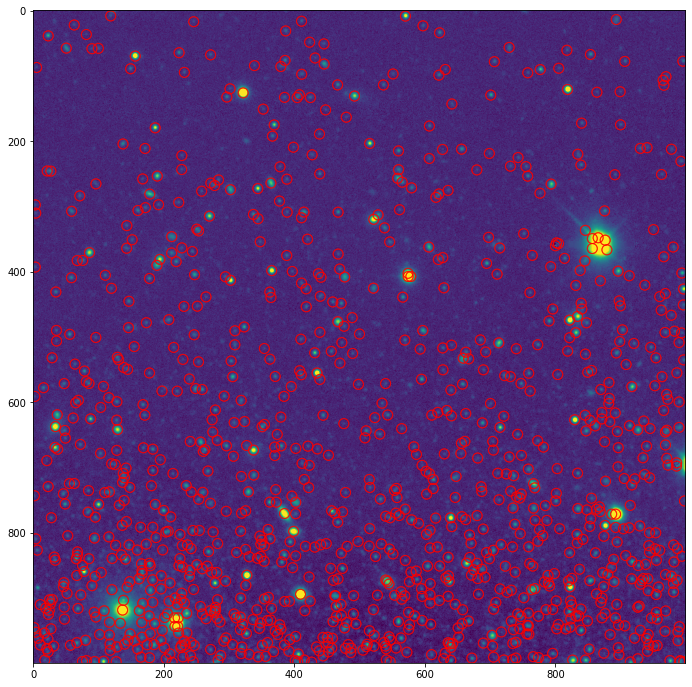

In [18]:
plt.figure(figsize=(12, 12))
visualization.imshow_norm(edge_data_r, 
                          interval=visualization.AsymmetricPercentileInterval(.1, 99.8),
                          stretch=visualization.AsinhStretch())
msk = res['flux_fit'] > 0
plt.scatter(res['x_0'][msk], res['y_0'][msk], ec='r', fc='none', s=100, alpha=.5)

Cross compare to see how this looks relative to the catalog

In [19]:
x0, y0 = res['x_0'][msk], res['y_0'][msk]
xi, yi = psf_r_starlist_obj['X_IMAGE'], psf_r_starlist_obj['Y_IMAGE']

In [20]:
kdt = spatial.cKDTree(np.array((xi, yi)).T)

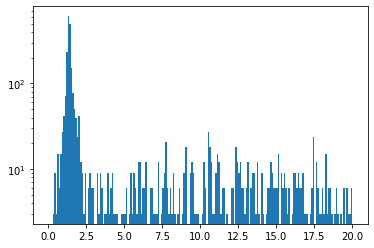

In [21]:
dpx, idx = kdt.query(np.array(((x0+5200, y0+8000))).T)
plt.hist(dpx, bins=200, range=(0, 20));
plt.semilogy();

In [22]:
matches = dpx < 2.5
matches_cat = psf_r_starlist_obj[idx[matches]]
matches_photutils = res[msk][matches]

In [23]:
matches_photutils

<Table length=1953>
       x_0               x_fit        ... group_id iter_detected
     float64            float64       ...  int64       int64    
------------------ ------------------ ... -------- -------------
 570.2757745465952  5646.144019840758 ...        2             1
 893.5319245905948  893.5319245905948 ...        3             1
411.04280882177375 411.04280882177375 ...        4             1
 597.2478117282725  597.2478117282725 ...        7             1
386.74358268527754 386.74358268527754 ...        8             1
 622.6702403733985  622.6702403733985 ...        9             1
               ...                ... ...      ...           ...
 283.1865266084816  283.1865266084816 ...     1095             3
 405.1727184750312  405.1727184750312 ...     1096             3
  639.938380122731   639.938380122731 ...     1097             3
 975.8633322926737  975.8633322926737 ...     1099             3
107.70861571223593 107.70861571223593 ...     1100             3
 93.79905618269379  93.79905618269379 ...     1102             3
 915.1395226126151  915.1395226126151 ...     1109             3

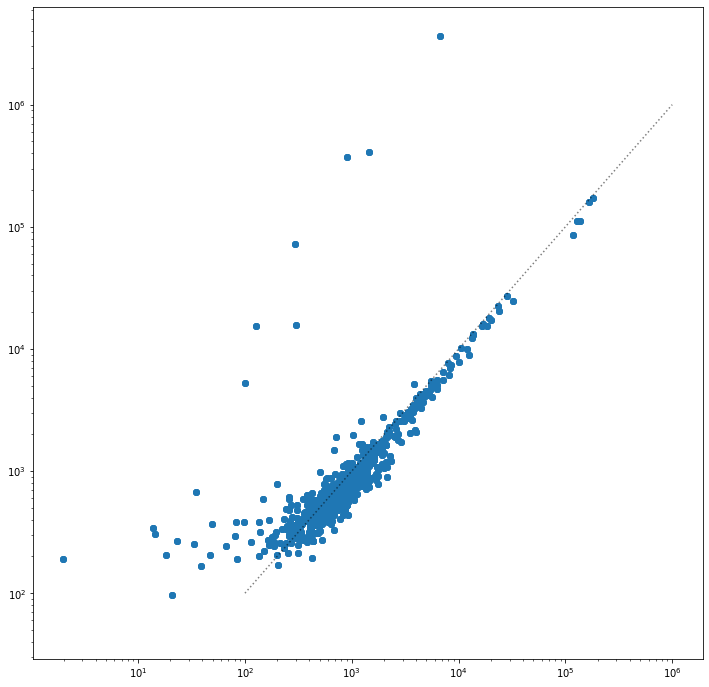

In [24]:
plt.figure(figsize=(12, 12))
plt.scatter(matches_cat['NORM_PSF'], matches_photutils['flux_fit'])
plt.loglog()
plt.plot([100, 1e6], [100, 1e6], c='k', ls=':', alpha=.5)

Hooray! It makes sense.

# Now use this model to inject an artificial star

In [25]:
psf_model_r_ast = psf_model_r.copy()
edge_data_r_ast = edge_data_r.copy()

#bbox_size = 25
#psf_model_r_ast.bounding_box = ((-bbox_size, bbox_size), (-bbox_size, bbox_size))

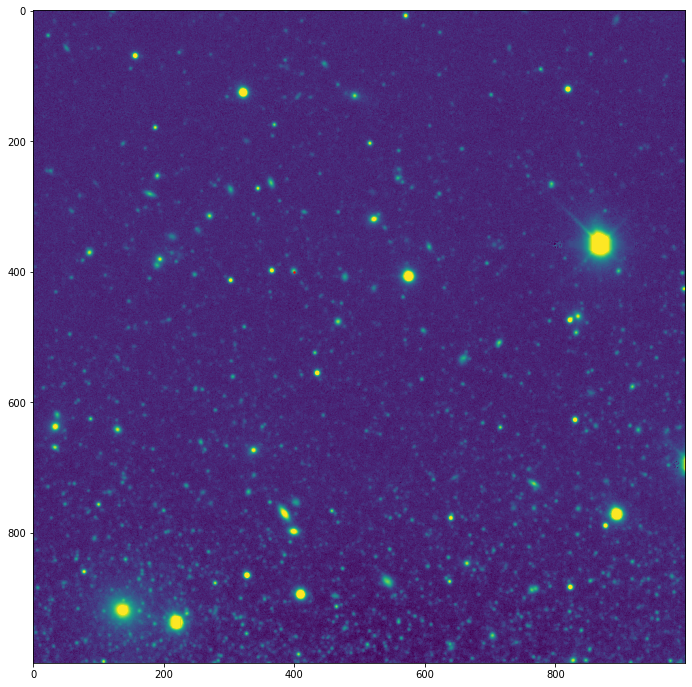

In [26]:
psf_model_r_ast.flux = 2000
psf_model_r_ast.x_0 = 400
psf_model_r_ast.y_0 = 400

xg, yg = np.meshgrid(np.arange(edge_data_r_ast.shape[0]), np.arange(edge_data_r_ast.shape[1]))
psf_model_r_ast.render(edge_data_r_ast, coords=[xg-psf_model_r_ast.x_0, yg-psf_model_r_ast.y_0])

fig = plt.figure(figsize=(12, 12))
visualization.imshow_norm(edge_data_r_ast, 
                          interval=visualization.AsymmetricPercentileInterval(.1, 99.8),
                          stretch=visualization.AsinhStretch())
plt.scatter([psf_model_r_ast.x_0.value], [psf_model_r_ast.y_0.value], c='r',s=2)


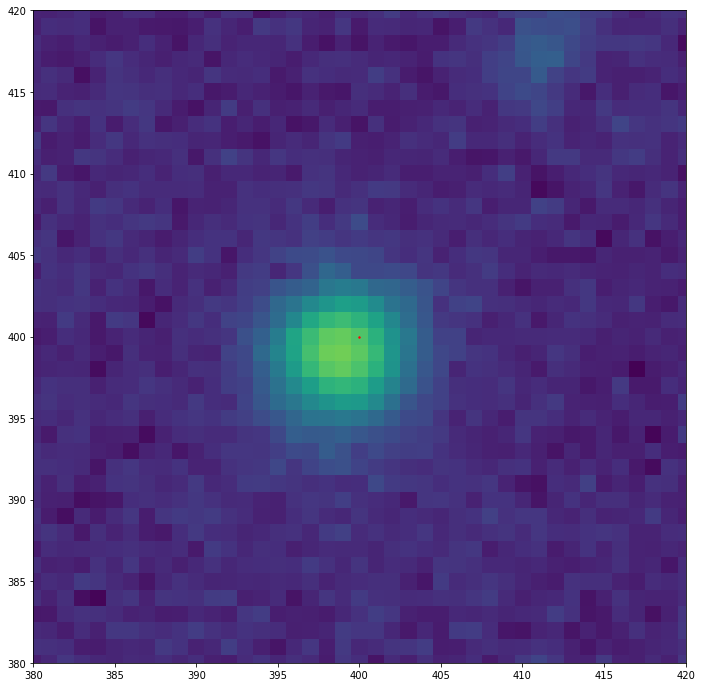

In [27]:
fig.axes[0].set_xlim(380, 420)
fig.axes[0].set_ylim(380, 420)
fig

We're off-by-1, but that's just a pixel-numbering issue in scatter I think?

In [28]:
imviz.load_data(edge_data_r_ast)
imviz.default_viewer.set_colormap('viridis')
imviz.default_viewer.stretch = 'log'

imviz.default_viewer.center_on((psf_model_r_ast.x_0.value, psf_model_r_ast.y_0.value))
imviz.default_viewer.zoom_level = 5